For each player, summarize their behavior into 2 simple statistics:
- Mean reward across all rounds.
- Mean regret across all rounds.

Visualize players on 2D plane: x = average reward, y = average regret.

K-means clustering into 2 groups:
- One group should correspond to colluders (high reward, possibly weird regret).
- Other group should correspond to honest players (lower, noisier reward/regret).

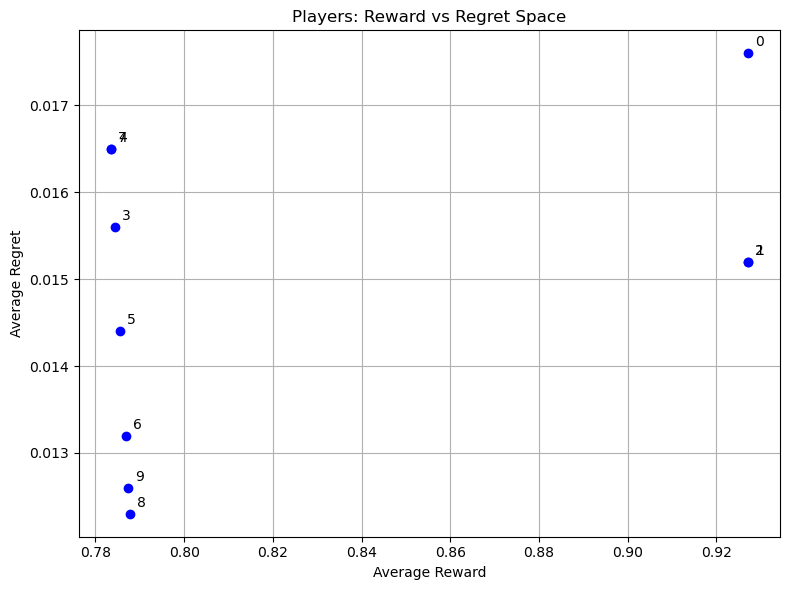

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


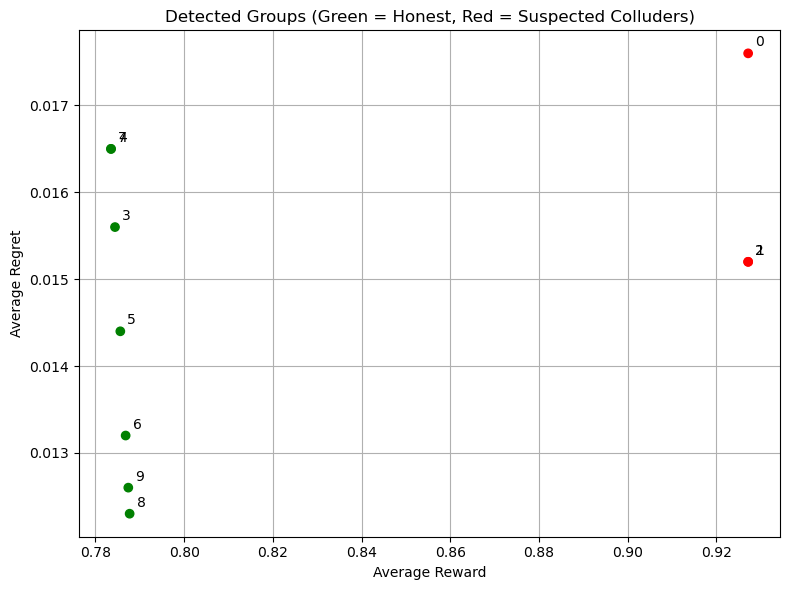

Detected 'colluder' players (label=1): [0 1 2]
Detected 'honest' players (label=0): [3 4 5 6 7 8 9]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# === DETECTION BASED ON FINAL HISTORY ===

# Feature Construction:
# For each player, compute:
# - Average reward over all rounds
# - Average regret over all rounds

history_rewards = np.load('game_implementation/history_rewards.npy')
history_regrets = np.load('game_implementation/history_regrets.npy')

num_players, num_rounds = history_rewards.shape

avg_rewards = history_rewards.mean(axis=1)
avg_regrets = history_regrets.mean(axis=1)

# Stack into feature matrix [reward, regret]
features = np.vstack([avg_rewards, avg_regrets]).T

# === Plot feature space (for visualization) ===
plt.figure(figsize=(8, 6))
plt.scatter(avg_rewards, avg_regrets, c='blue')
for i in range(num_players):
    plt.annotate(str(i), (avg_rewards[i], avg_regrets[i]), textcoords="offset points", xytext=(5,5))
plt.xlabel('Average Reward')
plt.ylabel('Average Regret')
plt.title('Players: Reward vs Regret Space')
plt.grid(True)
plt.tight_layout()
plt.show()

# === Clustering to Detect Colluders ===

# Assume we want 2 clusters: colluders and honest players
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(features)

# === Visualize Clustering Result ===
plt.figure(figsize=(8, 6))
colors = ['red' if label == 1 else 'green' for label in labels]
plt.scatter(avg_rewards, avg_regrets, c=colors)
for i in range(num_players):
    plt.annotate(str(i), (avg_rewards[i], avg_regrets[i]), textcoords="offset points", xytext=(5,5))
plt.xlabel('Average Reward')
plt.ylabel('Average Regret')
plt.title('Detected Groups (Green = Honest, Red = Suspected Colluders)')
plt.grid(True)
plt.tight_layout()
plt.show()

# === Print detected groups
print("Detected 'colluder' players (label=1):", np.where(labels == 1)[0])
print("Detected 'honest' players (label=0):", np.where(labels == 0)[0])


DTW (Dynamic Time Warping) compares entire reward time-series curves.
- Colluders tend to have very synchronized reward growth because they coordinate.
- Honest players have independent noisy growth paths.
- We cluster based on DTW distances instead of just final averages.
- This makes detection much more resilient against noise and time-based variance.

In [23]:
!pip install tslearn

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


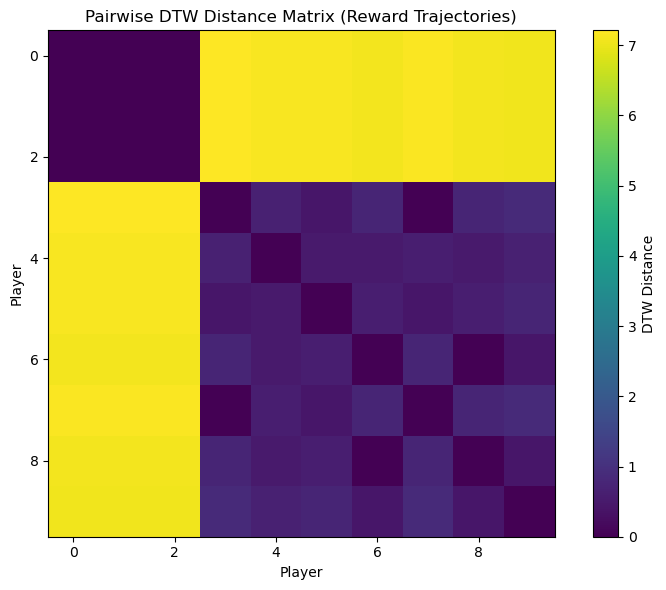

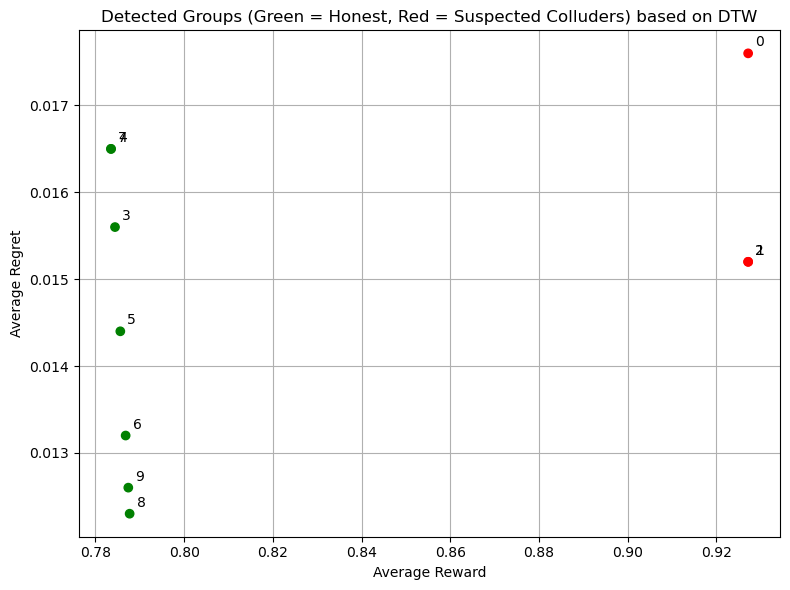

Detected 'colluder' players (label=1): [0 1 2]
Detected 'honest' players (label=0): [3 4 5 6 7 8 9]


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from tslearn.metrics import dtw
from sklearn.cluster import AgglomerativeClustering

# ==== Load history arrays ====
history_rewards = np.load('game_implementation/history_rewards.npy')
history_regrets = np.load('game_implementation/history_regrets.npy')

num_players, num_rounds = history_rewards.shape

# ==== Build Time Series Features ====
# You can choose rewards or regrets (both work, but rewards usually show collusion better)
series = history_rewards  # shape (num_players, num_rounds)

# ==== Compute Pairwise DTW Distances ====
dtw_distance_matrix = np.zeros((num_players, num_players))

for i in range(num_players):
    for j in range(i+1, num_players):
        distance = dtw(series[i], series[j])
        dtw_distance_matrix[i, j] = distance
        dtw_distance_matrix[j, i] = distance

# ==== Clustering ====
# Agglomerative clustering on the DTW distance matrix
clustering = AgglomerativeClustering(
    n_clusters=2,         # Assume 2 groups: colluders vs honest
    affinity='precomputed',
    linkage='average'
)
labels = clustering.fit_predict(dtw_distance_matrix)

# ==== Plot DTW Distance Matrix ====
plt.figure(figsize=(8, 6))
plt.imshow(dtw_distance_matrix, cmap='viridis')
plt.colorbar(label='DTW Distance')
plt.title('Pairwise DTW Distance Matrix (Reward Trajectories)')
plt.xlabel('Player')
plt.ylabel('Player')
plt.tight_layout()
plt.show()

# ==== Scatter the players (using average reward and regret for visualization) ====
avg_rewards = history_rewards.mean(axis=1)
avg_regrets = history_regrets.mean(axis=1)

colors = ['red' if label == 1 else 'green' for label in labels]

plt.figure(figsize=(8, 6))
plt.scatter(avg_rewards, avg_regrets, c=colors)
for i in range(num_players):
    plt.annotate(str(i), (avg_rewards[i], avg_regrets[i]), textcoords="offset points", xytext=(5,5))
plt.xlabel('Average Reward')
plt.ylabel('Average Regret')
plt.title('Detected Groups (Green = Honest, Red = Suspected Colluders) based on DTW')
plt.grid(True)
plt.tight_layout()
plt.show()

# ==== Output results ====
print("Detected 'colluder' players (label=1):", np.where(labels == 1)[0])
print("Detected 'honest' players (label=0):", np.where(labels == 0)[0])
